In [74]:
import warnings; warnings.filterwarnings("ignore")
import os;
from sys import platform
print(os.getcwd())
if platform == "darwin":
    os.chdir('/Users/ziyingc/Dropbox/Lab/MotorCortex')
elif platform == "win32":
    os.chdir('D:\Dropbox\Lab\MotorCortex')
print(os.getcwd())
import numpy as np
import comparison as cmp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Patch as patch
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm; 
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pycwt as wavelet; mother = wavelet.Morlet(6)
from scipy import stats
import read_data as rd;   import time2frequency as t2f
import behavior_track as bt ; import behavior_plot as bp ; import turning_track  as tt
import philters
fps = 30; fs_out = 1000; fs = 30000; T = 1/fs_out;
N = int((1/fps)/T/2+1);

sgn   = ['***','**','*']
P_sgn = np.array([0.0001, 0.001, 0.05])

D:\Dropbox\Lab\MotorCortex
D:\Dropbox\Lab\MotorCortex


In [93]:
erfdn = np.load('Rats/Rats_LT_ephy.npy')#[[1]]
# erfdn = np.load('Rats/Rats_Turn_ephy.npy')
mode = 'FFT'
f = np.load('Rats/freqs_'+mode+'_'+str(fs_out)+'.npy');x_fit = np.log10(f); 


idx_f1_fit = np.logical_and(f>=12.50, f<=15.00);
idx_f2_fit = np.logical_and(f>=50.00, f<=57.50); idx_f_fit = np.logical_or(idx_f1_fit, idx_f2_fit);
for rfdn in erfdn:
    
    epn    = np.load(rfdn+'tracking'+'/epn_LT_post.npy')
#     epn    = np.load(rfdn+'tracking'+'/epn_turn_elec_post.npy')
    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    slope_l, intercept_l, slope_i, intercept_i, intercept_li = \
    t2f.flicker_fit_fft(rfdn, epn, fs_out, subset, f, idx_f_fit, mode)
    slope     = np.array([slope_l,     slope_i]);
    intercept = np.array([intercept_l, intercept_i]);

    np.save(rfdn+'tracking'+'/slope_epn_LT_post.npy',    slope)
    np.save(rfdn+'tracking'+'/intercept_epn_LT_post.npy',intercept)
#     np.save(rfdn+'tracking'+'/slope_epn_turn_elec_post.npy',    slope)
#     np.save(rfdn+'tracking'+'/intercept_epn_turn_elec_post.npy',intercept)

Astro 17
Lenny 11
Quartus 15


In [7]:
# erfdn = np.load('Rats/Rats_Turn_ephy.npy')#[[1,3]]

N_win = 10
f_win = np.hanning(N_win)
f_win = f_win/np.sum(f_win)
rr = 0
fig = plt.figure(1, figsize=(1, 1))
for rfdn in erfdn:

    epn    = np.load(rfdn+'tracking'+'/epn_turn_elec_post.npy')#[[0,1,2]];
    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    
    rc = int(len(epn)/3)+1
    
    fig.set_figheight(rc*4); fig.set_figwidth(4*9)
    gs  = GridSpec(rc , 9);
    print(rfdn[9:len(rfdn)-1], len(epn))
    print(rc,  6, rc*3, 3*6)
    cov_avg = np.zeros((l_fb,l_fb,2)); 
    kk = 0
    for k in epn:
        fdn = rfdn + k + '/'
        spd_f = np.load(fdn+'tracking/'+'spd_f.npy'); spd_f = np.convolve(spd_f, f_win, mode='same')
        pos_X = np.load(fdn+'tracking/'+'pos_X_f.npy');
        pos_Y = np.load(fdn+'tracking/'+'pos_Y_f.npy');
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean   = np.logical_and(idx_clean_f, idx_clean_fft)
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
        
        idx_peak_acl = np.load(fdn + 'FFT_'+str(fs_out) + '/t_acc_f.npy');
        idx_pre_ac = np.zeros((l_t,))>1;
        if len(idx_peak_acl)>0:
            
            for i in np.arange(len(idx_peak_acl)):
                t_ref = idx_peak_acl[i]
                idx_t_spec = np.arange(t_ref,t_ref+100).astype('int')
                idx_pre_ac[idx_t_spec] = True
#         idx_speed = spd_f>1;
        idx_clean = np.logical_and(idx_clean, idx_pre_ac)
        
        ax_idx = gs[kk]; ax = fig.add_subplot(ax_idx);
        ax.plot(pos_X, pos_Y, 'r.', ms=0.2); 
        ax.set_xlim([0,150]); ax.set_ylim([0,150])
        kk += 1
        ii = 0
        for i in subset: 
            chn = str(i//10)+str(i%10)
            brst = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.burst.npy')
            brst = brst[:,idx_clean]
            cov_m = np.corrcoef(brst)
#             cov_m = np.cov(brst)
            cov_avg[:,:,ii] = cov_avg[:,:,ii]+cov_m
            ax_idx = gs[kk]; ax = fig.add_subplot(ax_idx);
            im = ax.pcolormesh(f_band, f_band, cov_m, 
                               vmin = -0.1,
                               vmax = 0.5,
                               cmap=cm.jet);
            fig.colorbar(im, ax=ax);

            ax.tick_params(labelsize=5);

            ax.set_title(k[10:21]+'  '+str(np.round(l_t/30/60,2)));
            kk += 1
            ii += 1
    kk += 1
    ax_idx = gs[kk]; ax = fig.add_subplot(ax_idx);
    im = ax.pcolormesh(f_band, f_band, cov_avg[:,:,0]/len(epn), 
                               vmin = -0.1,
                               vmax = 0.5,
                       cmap=cm.jet);
    fig.colorbar(im, ax=ax); ax.tick_params(labelsize=5);
    ax.set_title(k[10:21]+'  '+str(np.round(l_t/30/60,2)));
    kk += 1
    ax_idx = gs[kk]; ax = fig.add_subplot(ax_idx);
    im = ax.pcolormesh(f_band, f_band, cov_avg[:,:,1]/len(epn), 
                               vmin = -0.1,
                               vmax = 0.5,
                       cmap=cm.jet);
    fig.colorbar(im, ax=ax); ax.tick_params(labelsize=5);
    ax.set_title(k[10:21]+'  '+str(np.round(l_t/30/60,2)));
    
    print(' ')
    rr += 1
    plt.savefig('pic2/matrix_'+rfdn[9:(len(rfdn)-1)]+'.png')
    plt.clf()

Outlaw 48
17 6 51 18
 
Swashbuckler 13
5 6 15 18
 
Drifter 24
9 6 27 18
 


<Figure size 2592x2592 with 0 Axes>

Astro 17
2.37119960936
Lenny 11
1.65169100041
Quartus 15
1.45329100937


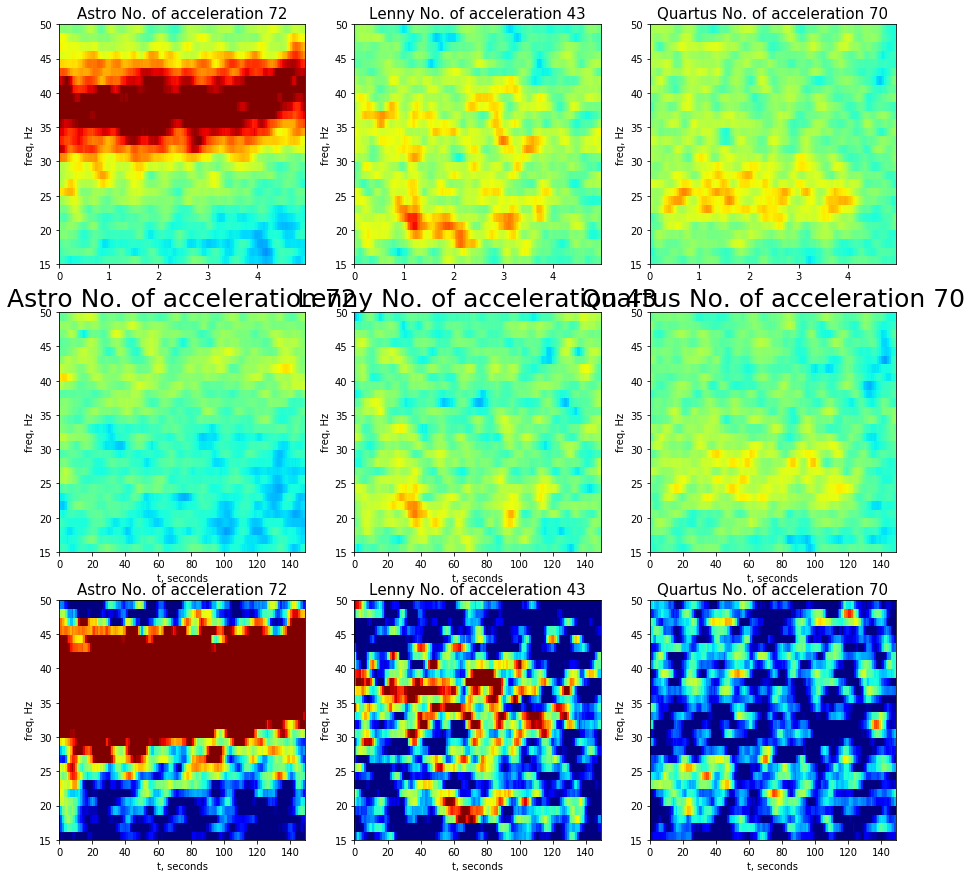

In [96]:
idx_band =  np.logical_and(f>=15, f<=50)
f_band = f[idx_band]
l_fb = len(f_band)
f_win = np.ones((len(f[idx_band]),))

T1 = np.load('Rats/T1.npy');
T2 = np.load('Rats/T2.npy');

# erfdn = np.load('Rats/Rats_Turn_ephy.npy')
erfdn = np.load('Rats/Rats_LT_ephy.npy')#[[0,1]]
n_r = len(erfdn)

fig = plt.figure(1, figsize=(1, 1))

fig.set_figheight(15); fig.set_figwidth(15)
gs  = GridSpec(3 , 3);

rr = 0
for rfdn in erfdn:
    

    
#     epn    = np.load(rfdn+'tracking'+'/epn_turn_elec_post.npy')
#     slope     = np.load(rfdn+'tracking'+'/slope_epn_turn_elec_post.npy')
#     intercept = np.load(rfdn+'tracking'+'/intercept_epn_turn_elec_post.npy')
    
    epn    = np.load(rfdn+'tracking'+'/epn_LT_post.npy')
    slope     = np.load(rfdn+'tracking'+'/slope_epn_LT_post.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_LT_post.npy')
    
    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    n_k = len(epn)
    
    cor_f   = np.zeros((n_k,l_fb))
    cor_f_x = np.zeros((n_k,l_fb))
    idx_k   = np.zeros((n_k,))>1
    T_pre = 0
    Y_acc_l = np.zeros((l_fb, T2+T_pre));
    Y_acc_i = np.zeros((l_fb, T2+T_pre));
    n_acc_total = 0
    kk = 0
    for k in epn:
        fdn = rfdn + k + '/'
        spd_f   = np.load(fdn+'tracking/'+'spd_f.npy');
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean   = np.logical_and(idx_clean_f, idx_clean_fft)
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
        T_ts = len(ts_f[idx_clean])/fps/60
        
        i_ref = 0;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy').T
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_l = (Y_f.T/y_fit)[:,idx_band]

        i_ref = 1;   i = subset[i_ref];    chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy').T
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);  Y_f_fit_i = (Y_f.T/y_fit)[:,idx_band]
        
        
        idx_acc_f = np.load(fdn+'tracking/idx_acc_f.npy');
        T_acc_f = np.load(fdn+'tracking/T_acc_f.npy');
        n_acc = len(idx_acc_f)
        n_acc_total = n_acc_total+n_acc
        idx_pre_ac = np.zeros((l_t,))>1;
        if n_acc>0:
            idx_k[kk] = True
            for i in np.arange(len(idx_acc_f)):
                T_ref = T_acc_f[i]
                t_ref = idx_acc_f[i]#+T_ref
                idx_t_spec = np.arange(t_ref-T_pre,t_ref+T2).astype('int')
                idx_pre_ac[idx_t_spec] = True
                Y_acc_l = Y_acc_l + Y_f_fit_l[idx_t_spec,:].T
                Y_acc_i = Y_acc_i + Y_f_fit_i[idx_t_spec,:].T
#                 ax_idx = gs[1,rr];ax = fig.add_subplot(ax_idx)
#                 ax.plot((idx_t_spec-idx_t_spec[0])/fps, spd_f[idx_t_spec], lw =0.5)


    
    
            idx_pre_ac = np.logical_and(idx_pre_ac, idx_clean)
        kk += 1
    Y_acc_l_m = Y_acc_l/n_acc_total
    Y_acc_i_m = Y_acc_i/n_acc_total
    
    ax_idx = gs[0,rr]; ax = fig.add_subplot(ax_idx);
    im = ax.pcolormesh((idx_t_spec-idx_t_spec[0])/fps, f_band, Y_acc_l_m, 
                               vmin = 0.3,
                               vmax = 1.8,
                       cmap=cm.jet);
#     fig.colorbar(im, ax=ax);
    print(np.max(Y_acc_l_m))
    ax.tick_params(labelsize=10);
    ax.set_title(rfdn[9:len(rfdn)-1]+' No. of acceleration '+str(n_acc_total), fontsize=15);
    
    ax.set_ylabel('freq, Hz')
    
    ax_idx = gs[1,rr]; ax = fig.add_subplot(ax_idx);
    im = ax.pcolormesh(idx_t_spec-idx_t_spec[0], f_band, Y_acc_i_m, 
                               vmin = 0.3,
                               vmax = 1.8,
                       cmap=cm.jet);
#     fig.colorbar(im, ax=ax);
    ax.tick_params(labelsize=10);
    ax.set_title(rfdn[9:len(rfdn)-1]+' No. of acceleration '+str(n_acc_total), fontsize=25);
    ax.set_xlabel('t, seconds')
    ax.set_ylabel('freq, Hz')
    
    ax_idx = gs[2,rr]; ax = fig.add_subplot(ax_idx);
    im = ax.pcolormesh(idx_t_spec-idx_t_spec[0], f_band, Y_acc_l_m-Y_acc_i_m, 
                               vmin = 0.0,
                               vmax = 0.3,
                       cmap=cm.jet);
#     fig.colorbar(im, ax=ax);
    ax.tick_params(labelsize=10);
    ax.set_title(rfdn[9:len(rfdn)-1]+' No. of acceleration '+str(n_acc_total), fontsize=15);
    ax.set_xlabel('t, seconds')
    ax.set_ylabel('freq, Hz')



#     ax_idx = gs[1,rr];ax = fig.add_subplot(ax_idx)
#     ax.set_ylim([0,20]);ax.set_xlim([0,(T2+T_pre)/fps]);
#     ax.set_xlabel('t, seconds')
#     ax.set_ylabel('speed, cm/s')
#     ax_idx = gs[2,rr];ax = fig.add_subplot(ax_idx)
#     y_acc_l_m_T1 = np.mean(Y_acc_l_m[:,0:T1-15],axis=1)
#     y_acc_l_m_T2 = np.mean(Y_acc_l_m[:,T1:T2],axis=1)
#     ax.plot(f_band, y_acc_l_m_T1,'r')
#     ax.plot(f_band, y_acc_l_m_T2,'b')
#     ax.plot(f_band, y_acc_l_m_T1/y_acc_l_m_T2,'b--')
    
#     plt.savefig('pic2/matrix_'+rfdn[9:(len(rfdn)-1)]+'.png')
#     plt.clf()
    rr += 1

band frequency: [ 1.]
Outlaw 48
Swashbuckler 13
Drifter 24


Text(0.5,0.98,'average Beta burst rate in lesion and intact side of motor cortex\n paired t-test *:p<0.05, **:p<0.001, ***:p<0.0001')

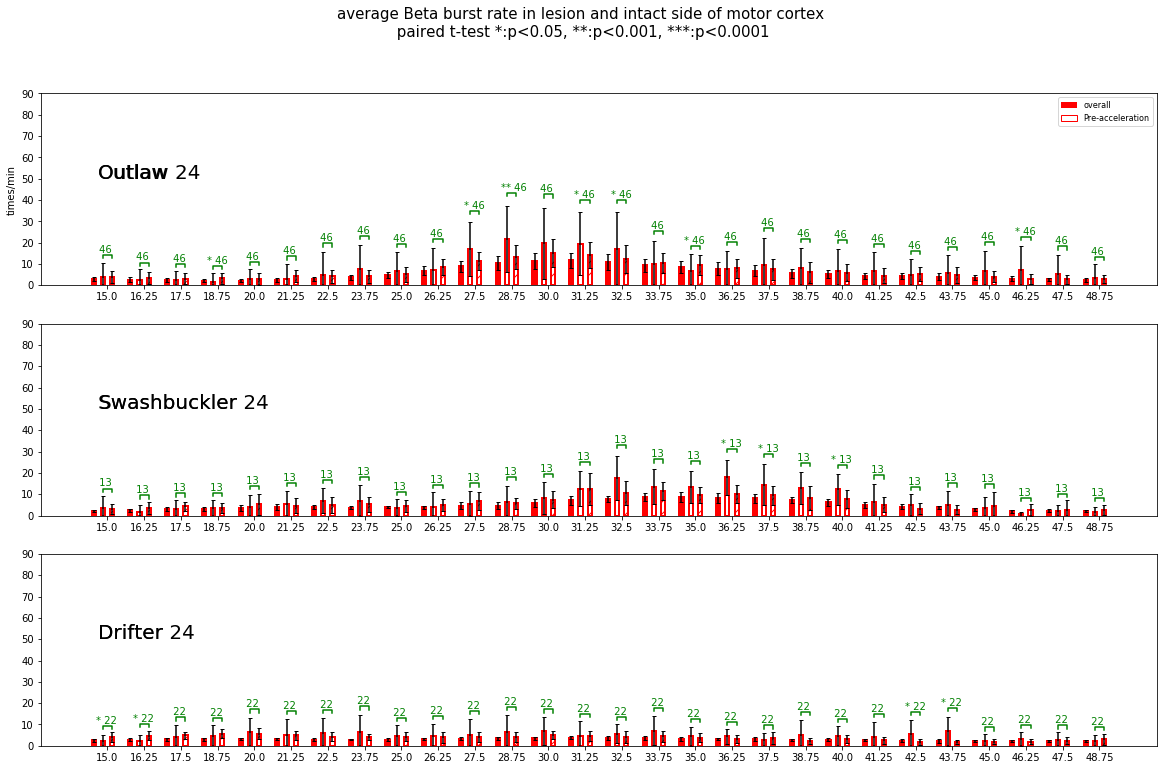

In [163]:
erfdn = np.load('Rats/Rats_Turn_ephy.npy')
# erfdn = np.load('Rats/Rats_LT_ephy.npy')[[0,1,2,3]]
mode = 'FFT'
f = np.load('Rats/freqs_'+mode+'_'+str(fs_out)+'.npy');x_fit = np.log10(f); 
test = False
flr = np.arange(15, 50, 1.25); rc  = len(erfdn)
fhr = flr+1.24;

idx_band =  np.logical_and(f>=flr[0], f<=fhr[0])
# f_win = np.hanning(len(f[idx_band]));
f_win = np.hamming(len(f[idx_band]));
# f_win = np.ones((len(f[idx_band]),))
print('band frequency:',f_win)

sgn   = ['***','**','*']
P_sgn = np.array([0.0001, 0.001, 0.05])

fig = plt.figure(1, figsize=(20, rc*4))
gs  = GridSpec(rc , 1);
xtk    = np.arange(1, 4*len(flr)+1, 4)
xticklabel = [];
rr = 0
for rfdn in erfdn:
    
    epn    = np.load(rfdn+'tracking'+'/epn_turn_elec_post.npy')
    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    
    slope     = np.load(rfdn+'tracking'+'/slope_epn_turn_elec_post.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_turn_elec_post.npy')
    
    rt_brst    = np.empty((2,len(epn),len(flr)))
    rt_brst_ac = np.zeros((2,len(epn),len(flr)))-1;
    rt_brst_ref= np.zeros((2,len(epn),len(flr)))-1;
    
    T_ac  = np.zeros((len(epn),len(flr)))-1;
    T_brst  = np.empty((2,len(epn),len(flr)), dtype=object)
    i_brst  = np.empty((2,len(epn),len(flr)), dtype=object)
    i_brst_max = np.empty((2,len(epn),len(flr)), dtype=object)

    kk = 0
    for k in epn:
        fdn = rfdn + k + '/'
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');N_win = 10
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean   = np.logical_and(idx_clean_f, idx_clean_fft)
        
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)

        v_thr = 5 #6 cm/s
        T_ts = len(ts_f[idx_clean])/fps/60
        idx_spd = np.logical_and(idx_clean, spd_f <= v_thr)
        
        i_ref = 1
        i = subset[i_ref]
        chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy').T
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);     
        Y_f_fit_ref = (Y_f.T/y_fit)

        jj = 0
        for i in subset:
            chn = str(i//10)+str(i%10)
            Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy').T
            y_fit = 10**(x_fit*slope[jj,kk] + intercept[jj,kk]);     
            Y_f_fit = (Y_f.T/y_fit)
            for ii in np.arange(len(flr)):
                fl = flr[ii];     fh = fhr[ii]
                idx_band =  np.logical_and(f>=fl, f<=fh)
                P_f_ref = (np.matmul(Y_f_fit_ref[:,idx_band],f_win)/np.sum(f_win))[idx_clean]
                m_f     = np.mean(P_f_ref);
                md_f    = np.median(P_f_ref);
                std_f   = np.std(P_f_ref);
                thr1 = m_f+std_f*3
#                 thr1 = md_f*2.5
                
                thr2 = thr1/2
                
                P_f = np.matmul(Y_f_fit[:,idx_band],f_win)/np.sum(f_win)
#                 P_f = np.convolve(P_f, np.ones((2,))/2, mode='same' )

                index, T = philters.read_burst(P_f, thr2, thr1, idx_clean, 1)
                rt_brst[jj, kk, ii] = len(index)/T_ts; 
                T_brst [jj, kk, ii] = T; 
                i_brst [jj, kk, ii] = index;
                i_brts = np.empty((0,));

                for i_b in np.arange(len(index)):
                    i_brt = index[i_b];  T_brt = T[i_b]
                    i_brt_max = np.argmax(P_f[i_brt:i_brt+T_brt])

                    i_brts = np.append(i_brts, i_brt+i_brt_max)
                i_brst_max[jj, kk, ii] = i_brts

            jj = jj+1

        idx_peak_acl = np.load(fdn+'tracking/t_acc_f.npy');
        idx_pre_ac = np.zeros((l_t,))>1; T_pre_ac   = len(spd_f[idx_pre_ac])*(1/fps)/60;
        if len(idx_peak_acl)>0:
            for i in np.arange(len(idx_peak_acl)):
                t_ref = idx_peak_acl[i]
                idx_t_spec = np.arange(t_ref+30, t_ref+T2).astype('int')
                idx_pre_ac[idx_t_spec] = True
            idx_pre_ac = np.logical_and(idx_pre_ac, idx_clean);
            T_pre_ac   = len(spd_f[idx_pre_ac])*(1/fps)/60;
            
        idx_peak_ref = np.load(fdn+'tracking/t_ref_f.npy');
        idx_spd_nac = np.zeros((l_t,))>1; T_ts_v0 = len(spd_f[idx_spd_nac])*(1/fps)/60;
        if len(idx_peak_ref)>0:
            for i in np.arange(len(idx_peak_ref)):
                t_ref = idx_peak_ref[i]
                idx_t_spec = np.arange(t_ref+45, t_ref+45+210).astype('int')
                idx_spd_nac[idx_t_spec] = True
            idx_spd_nac = np.logical_and(idx_spd_nac, idx_clean);
            T_ts_v0   = len(spd_f[idx_spd_nac])*(1/fps)/60; 
            
            
            
#         idx_spd_nac = np.logical_and(idx_spd, np.logical_not(idx_pre_ac))
#         T_ts_v0 = len(ts_f[idx_spd_nac])/fps/60
            
        for ii in np.arange(len(flr)):
            T_ac[kk,ii] = T_pre_ac;
            fl = flr[ii];     fh = fhr[ii]
            T_l = T_brst [0, kk, ii]; idx_l = i_brst [0, kk, ii].astype('int'); 
            T_i = T_brst [1, kk, ii]; idx_i = i_brst [1, kk, ii].astype('int'); 

            idx_l_ac  = np.empty((0,));  idx_i_ac = np.empty((0,));
            idx_l_ref = np.empty((0,)); idx_i_ref = np.empty((0,));

            for i_b in np.arange(len(T_l)):
                i_brt   = idx_l[i_b];  T_brt = T_l[i_b]
                if np.sum(idx_pre_ac[i_brt:i_brt+T_brt])>0:
                    idx_l_ac = np.append(idx_l_ac, i_brt)
                if np.sum(idx_spd_nac[i_brt:i_brt+T_brt])>0:
                    idx_l_ref = np.append(idx_l_ref, i_brt)

            for i_b in np.arange(len(T_i)):
                i_brt   = idx_i[i_b];  T_brt = T_i[i_b]
                if np.sum(idx_pre_ac[i_brt:i_brt+T_brt])>0:
                    idx_i_ac = np.append(idx_i_ac, i_brt)
                if np.sum(idx_spd_nac[i_brt:i_brt+T_brt])>0:
                    idx_i_ref = np.append(idx_i_ref, i_brt)
            if T_pre_ac>0:
                rt_brst_ac [0, kk, ii] = len(idx_l_ac)/T_pre_ac;
                rt_brst_ac [1, kk, ii] = len(idx_i_ac)/T_pre_ac;
            if T_ts_v0>0:
                rt_brst_ref[0, kk, ii] = len(idx_l_ref)/T_ts_v0;
                rt_brst_ref[1, kk, ii] = len(idx_i_ref)/T_ts_v0;
        kk = kk+1
        
    for ii in np.arange(len(flr)):
        chn = 0
        idx_ac_i = np.logical_and(rt_brst_ac[chn,:,ii]>=0, rt_brst_ref[chn,:,ii]>=0)
        
        brt_i_m    = np.mean(rt_brst    [chn, idx_ac_i,ii]);  brt_i_s    = np.std(rt_brst    [chn,idx_ac_i,ii])
        brt_i_ac_m = np.mean(rt_brst_ac [chn, idx_ac_i,ii]);  brt_i_ac_s = np.std(rt_brst_ac [chn,idx_ac_i,ii])
        brt_i_rf_m = np.mean(rt_brst_ref[chn, idx_ac_i,ii]);  brt_i_rf_s = np.std(rt_brst_ref[chn,idx_ac_i,ii])
        
#         t, p_ac  = stats.ttest_ind(rt_brst[chn,idx_ac_i,ii],   rt_brst_ac [chn, idx_ac_i, ii],  equal_var=False)
#         t, p_rf  = stats.ttest_ind(rt_brst[chn,idx_ac_i,ii],   rt_brst_ref[chn, idx_ac_i, ii],  equal_var=False)
#         t, p_l   = stats.ttest_ind(rt_brst_ac[chn,idx_ac_i,ii],rt_brst_ref[chn, idx_ac_i, ii],  equal_var=False)
        t, p_ac  = stats.ttest_rel(rt_brst[chn,idx_ac_i,ii],   rt_brst_ac [chn, idx_ac_i, ii])
        t, p_rf  = stats.ttest_rel(rt_brst[chn,idx_ac_i,ii],   rt_brst_ref[chn, idx_ac_i, ii])
        t, p_l   = stats.ttest_rel(rt_brst_ac[chn,idx_ac_i,ii],rt_brst_ref[chn, idx_ac_i, ii])
#         t, p_rf  = stats.ttest_rel(rt_brst[chn,idx_ac_i,ii],   rt_brst_ref[chn, idx_ac_i, ii])
      
        i = 0
        sign_l = ''
        while i < 3:
            if p_l<P_sgn[i]: sign_l = sgn[i]; break
            else: i = i+1
        
        ax_idx = gs[rr]; ax = fig.add_subplot(ax_idx);
        ax.bar(xtk[ii]-1.5, brt_i_m,    yerr=brt_i_s,    width = 0.45,
               capsize=2, lw = 2, color='red', edgecolor = 'red')
        ax.bar(xtk[ii]-0.5, brt_i_ac_m, yerr=brt_i_ac_s, width = 0.45,
               capsize=2, lw = 2, facecolor='white', edgecolor = 'red')  
        ax.bar(xtk[ii]+0.5, brt_i_rf_m, yerr=brt_i_rf_s, width = 0.45,
               capsize=2, lw = 2, facecolor='white', edgecolor = 'red', hatch='//')
        
        h_l = brt_i_rf_m    + brt_i_rf_s;      h_i = brt_i_ac_m + brt_i_ac_s; h = np.max([h_l,h_i])*1.1
        ax.plot([xtk[ii]-0.5, xtk[ii]-0.5, xtk[ii]+0.5, xtk[ii]+0.5], 
                [h+1.0, h+2.5, h+2.5, h+1.0],              'green', lw=1.5)
        ax.text(xtk[ii]-1.2, h+3.5,  sign_l+' '+str(np.sum(idx_ac_i)), fontsize=10, color = 'green')

    rr = rr + 1


for ii in np.arange(len(flr)):
    fl = flr[ii];   fh = fhr[ii]
    xticklabel = np.append(xticklabel, str(fl));
for rr in np.arange(len(erfdn)):
    rfdn = erfdn[rr];
    ax_idx = gs[rr]; ax = fig.add_subplot(ax_idx);
    ax.text(xtk[0]-1, 50, rfdn[9:len(rfdn)-1]+' '+str(len(epn)), fontsize=20)
    ax.set_ylim([0, 50]);
    ax.set_xticklabels(xticklabel, fontsize=8);  ax.set_xticks(xtk)
    ax.tick_params(labelsize=10);
    ax.text(xtk[0]-1, 50, rfdn[9:len(rfdn)-1], fontsize=20)
ax_idx = gs[0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('times/min')
l_patch  = patch(facecolor='red',label='overall')
r_patch  = patch(facecolor='white', edgecolor = 'red', label='Pre-acceleration')
ax.legend(handles=[l_patch, r_patch], loc='upper right', fontsize=8)
fig.suptitle('average Beta burst rate in lesion and intact side of motor cortex'+
             '\n paired t-test *:p<0.05, **:p<0.001, ***:p<0.0001', fontsize=15)

In [126]:
erfdn = np.load('Rats/Rats_Turn_ephy.npy')#[[0,1,2]]
# erfdn = np.load('Rats/Rats_LT_ephy.npy')[[0,1,2,3]]
mode = 'FFT'
f = np.load('Rats/freqs_'+mode+'_'+str(fs_out)+'.npy');x_fit = np.log10(f); 
test = False
flr = np.arange(17.50, 45, 2.5); rc  = len(erfdn)
# flr  = np.array([25]); rc = 1
fhr = flr+1.25*4;

idx_band =  np.logical_and(f>=flr[0], f<=fhr[0])
f_win = np.hanning(len(f[idx_band]));
# f_win = np.hamming(len(f[idx_band]));
# f_win = np.ones((len(f[idx_band]),))

T1 = np.load('Rats/T1.npy')
T2 = np.load('Rats/T2.npy')

print('T1:',T1,'T2:',T2)
print('band frequency:',f_win)

sgn   = ['***','**','*']
P_sgn = np.array([0.0001, 0.001, 0.05])

fig = plt.figure(1, figsize=(20, rc*4))
gs  = GridSpec(rc , 1);
xtk    = np.arange(1, 4*len(flr)+1, 4)
xticklabel = [];
rr = 0
for rfdn in erfdn:
    
    epn    = np.load(rfdn+'tracking'+'/epn_turn_elec_post.npy')
    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    
    slope     = np.load(rfdn+'tracking'+'/slope_epn_turn_elec_post.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_turn_elec_post.npy')

    rt_brst_ac  = np.empty((2,len(epn),len(flr)), dtype=object);
    rt_brst_ref = np.empty((2,len(epn),len(flr)), dtype=object);
    rt_brst     = np.zeros((2,len(epn),len(flr)))
    T_brst      = np.empty((2,len(epn),len(flr)),    dtype=object)
    i_brst      = np.empty((2,len(epn),len(flr)),    dtype=object)

    kk = 0
    rt_ac  = np.empty((2,len(flr)), dtype=object);
    rt_ref = np.empty((2,len(flr)), dtype=object);
    for k in epn:
        fdn = rfdn + k + '/'
        spd_f   = np.load(fdn+'tracking/'+'spd_f.npy');
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean   = np.logical_and(idx_clean_f, idx_clean_fft)     
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)
        T_ts = len(ts_f[idx_clean])/fps/60
        idx_peak_acl = np.load(fdn+'tracking/t_acc_f.npy');
        l_acc = len(idx_peak_acl)
        if l_acc>0:
            idx_pre_ac = np.empty((l_acc,), dtype=object)
            for i in np.arange(l_acc):
                idx_pre_ac_i = np.zeros((l_t,))>1;
                t_ref = idx_peak_acl[i]
                idx_t_spec = np.arange(t_ref, t_ref+T1).astype('int')
                idx_pre_ac_i[idx_t_spec] = True
                idx_pre_ac[i] = idx_pre_ac_i
                
                
        idx_peak_ref = np.load(fdn+'tracking/t_ref_f.npy');
        l_ref = len(idx_peak_ref)
        if l_ref>0:
            idx_pre_ref = np.empty((l_ref,), dtype=object)
            for i in np.arange(l_ref):
                idx_pre_ref_i = np.zeros((l_t,))>1;
                t_ref = idx_peak_ref[i]
                idx_t_spec = np.arange(t_ref+T2,t_ref+T2+T1).astype('int')
                idx_pre_ref_i[idx_t_spec] = True
                idx_pre_ref[i] = idx_pre_ref_i    
                
        
        i_ref = 1
        i = subset[i_ref]
        chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy').T
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);     
        Y_f_fit_ref = (Y_f.T/y_fit)

        jj = 0
        for i in subset:
            chn = str(i//10)+str(i%10)
            Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy').T
            y_fit = 10**(x_fit*slope[jj,kk] + intercept[jj,kk]);     
            Y_f_fit = (Y_f.T/y_fit)
            for ii in np.arange(len(flr)):
                fl = flr[ii];     fh = fhr[ii]
                idx_band =  np.logical_and(f>=fl, f<=fh)
                P_f_ref = np.matmul(Y_f_fit_ref[:,idx_band],f_win)/np.sum(f_win)
                m_f     = np.mean(P_f_ref[idx_clean]);
                md_f    = np.median(P_f_ref[idx_clean]);
                std_f   = np.std(P_f_ref[idx_clean]);
#                 thr1 = md_f*3
#                 thr2 = thr1/2
                thr1 = m_f+std_f*2
                thr2 = m_f+std_f*0
                P_f = np.matmul(Y_f_fit[:,idx_band],f_win)/np.sum(f_win)
                index, T = philters.read_burst(P_f, thr2, thr1, idx_clean, 1)
                rt_brst[jj, kk, ii] = len(index)/T_ts
                T_brst [jj, kk, ii] = T; 
                i_brst [jj, kk, ii] = index;
                rt_brst_ac_i = np.zeros((l_acc,))
                rt_brst_ref_i = np.zeros((l_ref,))
                for j in np.arange(len(index)):
                    i_brt   = index[j];  T_brt = T[j]
                    idx_brst = np.zeros((l_t,))>1;
                    idx_brst[i_brt:i_brt+T_brt] = True
                    if l_acc>0:
                        for i_acc in np.arange(l_acc):
                            idx_crs = np.logical_and(idx_brst, idx_pre_ac[i_acc])
                            if np.sum(idx_crs)>0:
                                rt_brst_ac_i[i_acc] = rt_brst_ac_i[i_acc]+1;
                    if l_ref>0:
                        for i_ref in np.arange(l_ref):
                            idx_crs = np.logical_and(idx_brst, idx_pre_ref[i_ref])
                            if np.sum(idx_crs)>0:
                                rt_brst_ref_i[i_ref] = rt_brst_ref_i[i_ref]+1;         
    
                rt_ac [jj, ii] = np.append(rt_ac [jj, ii],  rt_brst_ac_i)
                rt_ref[jj, ii] = np.append(rt_ref[jj, ii],  rt_brst_ref_i)
                rt_brst_ac [jj, kk, ii] = rt_brst_ac_i
                rt_brst_ref[jj, kk, ii] = rt_brst_ref_i

            jj = jj+1
        kk = kk+1
    np.save(rfdn+'tracking'+'/rt_brst_ac.npy',  rt_brst_ac)
    np.save(rfdn+'tracking'+'/rt_ac.npy',       rt_ac)
    np.save(rfdn+'tracking'+'/rt_brst_ref.npy', rt_brst_ref)
    np.save(rfdn+'tracking'+'/rt_ref.npy',      rt_ref)
    rr = rr + 1


T1: 60 T2: 90
band frequency: [ 0.   0.5  1.   0.5  0. ]
Outlaw 48
Swashbuckler 13
Drifter 24
Unknown 7
Quartus 5


<Figure size 1440x1440 with 0 Axes>

Outlaw 49
Swashbuckler 13
Drifter 38
Unknown 7
Quartus 5


ZeroDivisionError: float division by zero

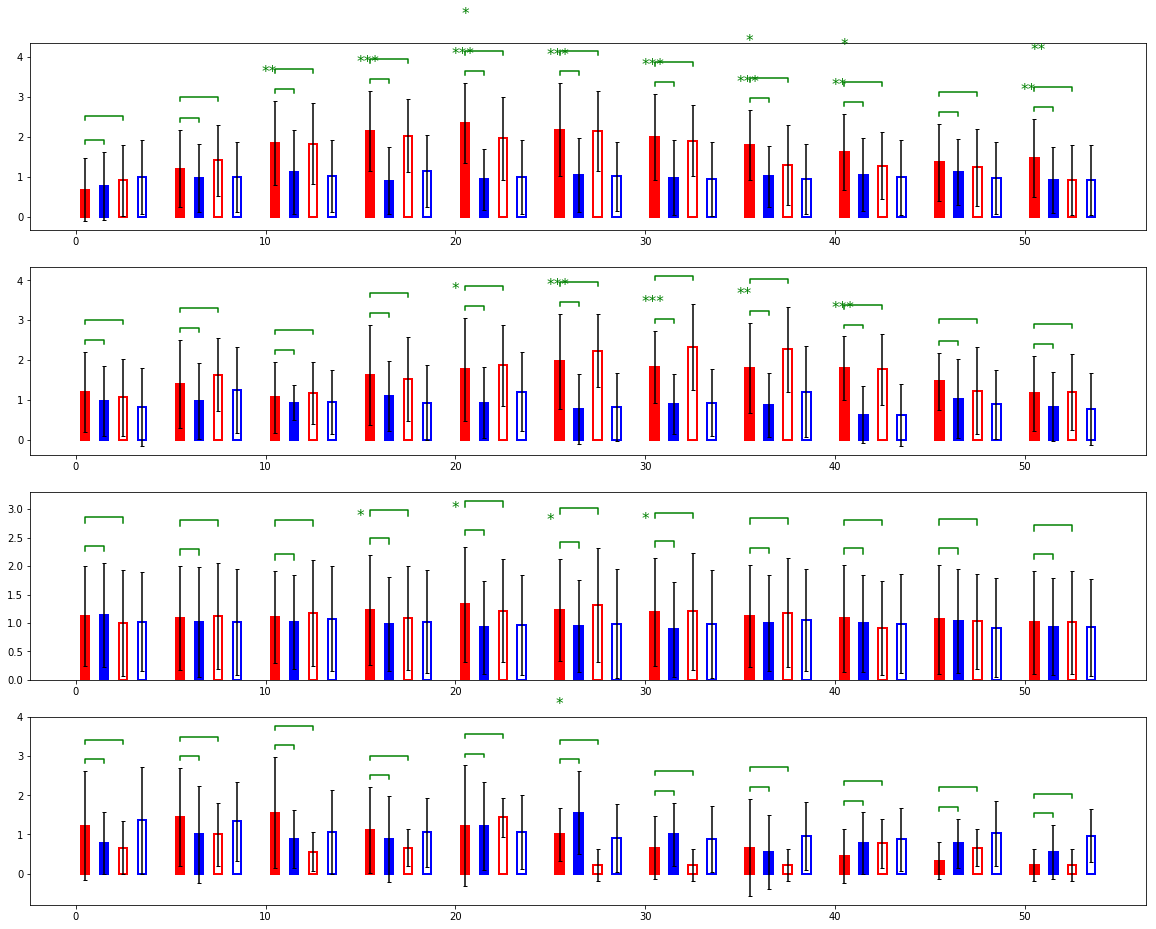

In [7]:
sgn   = ['***','**','*']
P_sgn = np.array([0.0001, 0.001, 0.05])

fig = plt.figure(1, figsize=(20, rc*4))
gs  = GridSpec(rc , 1);
xtk    = np.arange(1, 5*len(flr)+1, 5)
xticklabel = [];
rr = 0
for rfdn in erfdn:

    
    epn    = np.load(rfdn+'tracking'+'/epn_turn_elec_post.npy')
    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))

    rt_brst_ac  = np.load(rfdn+'tracking'+'/rt_brst_ac.npy')
    rt_ac       = np.load(rfdn+'tracking'+'/rt_ac.npy')
    rt_brst_ref = np.load(rfdn+'tracking'+'/rt_brst_ref.npy')
    rt_ref      = np.load(rfdn+'tracking'+'/rt_ref.npy')
    
    for ii in np.arange(len(flr)):
        
        rt_ac_l  = (rt_ac[0,ii])[1:len(rt_ac[0,ii])];  
        brt_ac_l_m = np.mean(rt_ac_l);   brt_ac_l_s = np.std(rt_ac_l)
        
        rt_ac_i  = (rt_ac[1,ii])[1:len(rt_ac[1,ii])]; 
        brt_ac_i_m = np.mean(rt_ac_i);   brt_ac_i_s = np.std(rt_ac_i)
        
        rt_ref_l = (rt_ref[0,ii])[1:len(rt_ac[0,ii])]; 
        brt_ref_l_m = np.mean(rt_ref_l); brt_ref_l_s = np.std(rt_ref_l)
        
        rt_ref_i = (rt_ref[1,ii])[1:len(rt_ref[1,ii])]; 
        brt_ref_i_m = np.mean(rt_ref_i); brt_ref_i_s = np.std(rt_ref_i)
        
        t, p_ac  = stats.ttest_ind(rt_ac_l,   rt_ac_i,  equal_var=False)
        t, p_rf  = stats.ttest_ind(rt_ref_l,  rt_ref_i, equal_var=False)
        
        t, p_l  = stats.ttest_ind(rt_ac_l,  rt_ref_l, equal_var=False)
        
        i = 0
        sign_ac = ''
        while i < 3:
            if p_ac<P_sgn[i]: sign_ac = sgn[i]; break
            else: i = i+1
        i = 0
        sign_rf = ''
        while i < 3:
            if p_rf<P_sgn[i]: sign_rf = sgn[i]; break
            else: i = i+1
        i = 0
        sign_l = ''
        while i < 3:
            if p_l<P_sgn[i]: sign_l = sgn[i]; break
            else: i = i+1
                
        ax_idx = gs[rr,0]; ax = fig.add_subplot(ax_idx);
        ax.bar(xtk[ii]-0.5, brt_ac_l_m,    yerr=brt_ac_l_s,    width = 0.45,
               capsize=2, lw = 2, color='red', edgecolor = 'red')
        ax.bar(xtk[ii]+0.5, brt_ac_i_m,    yerr=brt_ac_i_s,    width = 0.45,
               capsize=2, lw = 2, color='blue', edgecolor = 'blue')  

        h_l = brt_ac_l_m    + brt_ac_l_s;      h_i = brt_ac_i_m + brt_ac_i_s;
        h = np.max([h_l,h_i])+0.1
        
        ax.plot([xtk[ii]-0.5, xtk[ii]-0.5, xtk[ii]+0.5, xtk[ii]+0.5], 
                [h+0.1, h+0.2, h+0.2, h+0.1],              'green', lw=1.5)
        ax.text(xtk[ii]-1.2, h+.5,  sign_ac, fontsize=15, color = 'green')
        
        
        ax_idx = gs[rr,0]; ax = fig.add_subplot(ax_idx);
        ax.bar(xtk[ii]+1.5, brt_ref_l_m,    yerr=brt_ref_l_s,    width = 0.45,
               capsize=2, lw = 2, facecolor='white', edgecolor = 'red')
        ax.bar(xtk[ii]+2.5, brt_ref_i_m,    yerr=brt_ref_i_s,    width = 0.45,
               capsize=2, lw = 2, facecolor='white', edgecolor = 'blue')
        
        h_l = brt_ac_l_m    + brt_ac_l_s;      h_i = brt_ref_l_m + brt_ref_l_s;
        h = np.max([h_l,h_i,h])+0.5
        
        ax.plot([xtk[ii]-0.5, xtk[ii]-0.5, xtk[ii]+1.5, xtk[ii]+1.5], 
                [h+0.1, h+0.2, h+0.2, h+0.1],              'green', lw=1.5)
        
        ax.text(xtk[ii]-0.7, h+1.0,  sign_l, fontsize=15, color = 'green')
        
#         h_l = brt_ref_l_m + brt_ref_l_s;   h_i = brt_ref_i_m + brt_ref_i_s;
#         h = np.max([h_l,h_i])
        
#         ax.plot([xtk[ii]-0.5, xtk[ii]-0.5, xtk[ii]+0.5, xtk[ii]+0.5], 
#                 [h+0.1, h+0.2, h+0.2, h+0.1],              'brown', lw=1.5)
#         ax.text(xtk[ii]-1.2, h+.8,  sign_rf, fontsize=15, color = 'brown')
        
    
#     ax.text(xtk[0]-1, 50, rfdn[9:len(rfdn)-1]+' '+str(len(epn)), fontsize=20)
    rr = rr + 1
for ii in np.arange(len(flr)):
    fl = flr[ii];   fh = fhr[ii]
    xticklabel = np.append(xticklabel, str(fl) +'-' + str(fh));
for rr in np.arange(len(erfdn)):
    rfdn = erfdn[rr];
    ax_idx = gs[rr,0]; ax = fig.add_subplot(ax_idx);ax.set_ylim([0, 5]);
    ax.set_xticklabels(xticklabel, fontsize=8);  ax.set_xticks(xtk)
    ax.tick_params(labelsize=10);
    ax.text(xtk[0]-1, 3, rfdn[9:len(rfdn)-1], fontsize=20)
#     ax_idx = gs[rr,1]; ax = fig.add_subplot(ax_idx);ax.set_ylim([0, 5]);
    

In [207]:
# erfdn = np.load('Rats/Rats_LT_ephy.npy')
erfdn = np.load('Rats/Rats_Turn_ephy.npy')
mode = 'FFT'
f = np.load('Rats/freqs_'+mode+'_'+str(fs_out)+'.npy');x_fit = np.log10(f); 


idx_f1_fit = np.logical_and(f>=12.50, f<=16.25);
idx_f2_fit = np.logical_and(f>=50.00, f<=57.50); idx_f_fit = np.logical_or(idx_f1_fit, idx_f2_fit);
for rfdn in erfdn:
    
#     epn    = np.load(rfdn+'tracking'+'/epn_LT_post.npy')
    epn    = np.load(rfdn+'tracking'+'/epn_turn_elec_post.npy')
    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    slope_l, intercept_l, slope_i, intercept_i, intercept_li = \
    t2f.flicker_fit_fft(rfdn, epn, fs_out, subset, f, idx_f_fit, mode)
    slope     = np.array([slope_l,     slope_i]);
    intercept = np.array([intercept_l, intercept_i]);

#     np.save(rfdn+'tracking'+'/slope_epn_LT_post.npy',    slope)
#     np.save(rfdn+'tracking'+'/intercept_epn_LT_post.npy',intercept)
    np.save(rfdn+'tracking'+'/slope_epn_turn_elec_post.npy',    slope)
    np.save(rfdn+'tracking'+'/intercept_epn_turn_elec_post.npy',intercept)

Outlaw 48
Swashbuckler 13
Drifter 24


band frequency: [ 1.  1.  1.  1.  1.]
Outlaw 48
Swashbuckler 13
Drifter 24


Text(0.5,0.98,'average Beta burst rate in lesion and intact side of motor cortex\n paired t-test *:p<0.05, **:p<0.001, ***:p<0.0001')

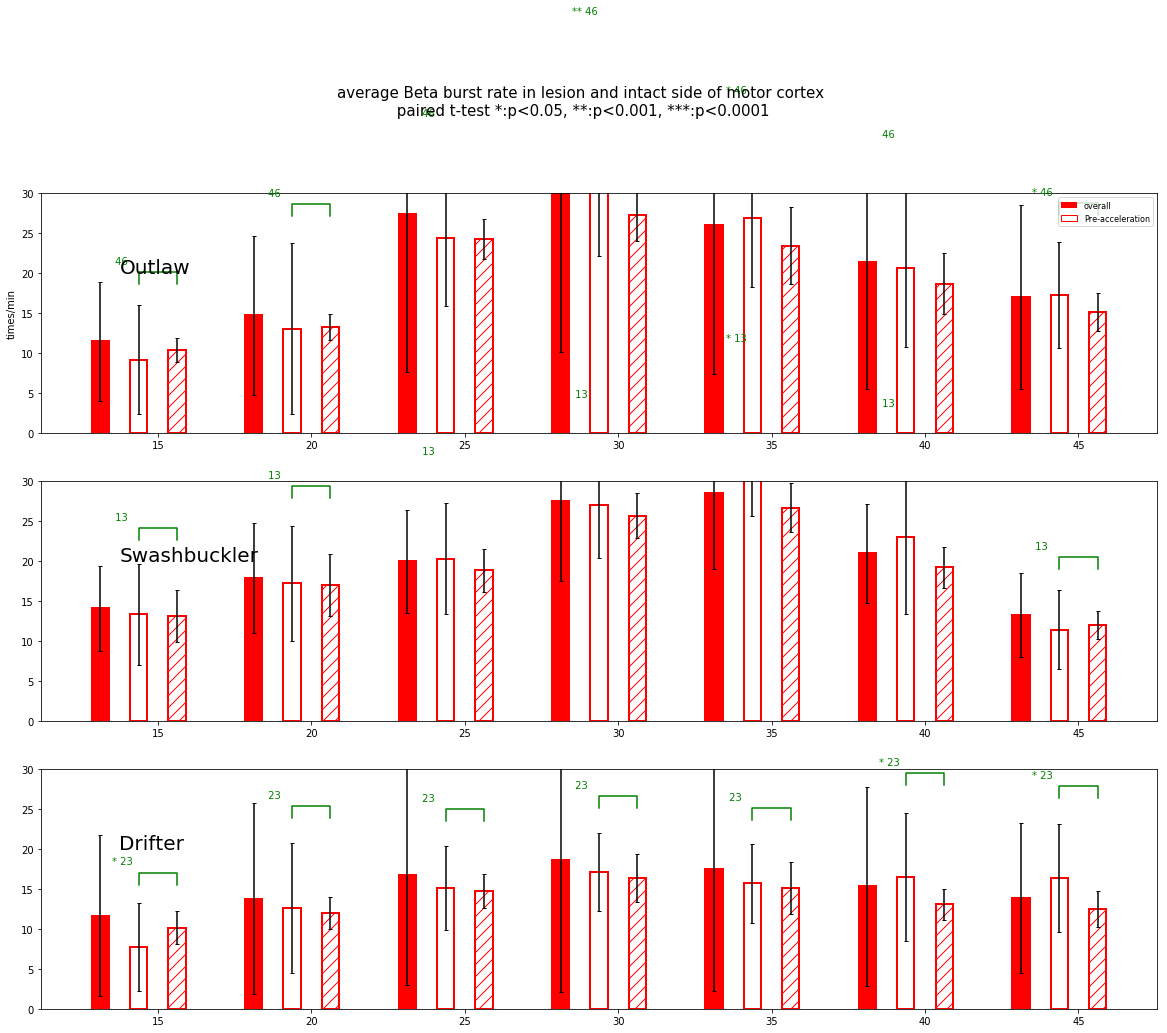

In [219]:
# erfdn = np.load('Rats/Rats_LT_ephy.npy')
erfdn = np.load('Rats/Rats_Turn_ephy.npy')
T1 = np.load('Rats/T1.npy')
T2 = np.load('Rats/T2.npy')
mode = 'FFT'
f = np.load('Rats/freqs_'+mode+'_'+str(fs_out)+'.npy');x_fit = np.log10(f); 
test = False
flr = np.arange(15, 50, 5); rc  = len(erfdn)
fhr = flr+5;

idx_band =  np.logical_and(f>=flr[0], f<=fhr[0])
# f_win = np.hanning(len(f[idx_band]));
# f_win = np.hamming(len(f[idx_band]));
f_win = np.ones((len(f[idx_band]),))
print('band frequency:',f_win)



fig = plt.figure(1, figsize=(20, rc*5))
gs  = GridSpec(rc , 1);
xtk    = np.arange(1, 4*len(flr)+1, 4)
xticklabel = [];
rr = 0
for rfdn in erfdn:
    
#     epn    = np.load(rfdn+'tracking'+'/epn_LT_post.npy')
#     slope     = np.load(rfdn+'tracking'+'/slope_epn_LT_post.npy')
#     intercept = np.load(rfdn+'tracking'+'/intercept_epn_LT_post.npy')
    epn    = np.load(rfdn+'tracking'+'/epn_turn_elec_post.npy')
    slope     = np.load(rfdn+'tracking'+'/slope_epn_turn_elec_post.npy')
    intercept = np.load(rfdn+'tracking'+'/intercept_epn_turn_elec_post.npy') 
    
    subset = np.load(rfdn+'tracking'+'/subset_ephy_li.npy');
    print(rfdn[9:len(rfdn)-1], len(epn))
    
    
    rt_brst    = np.empty((2,len(epn),len(flr)))
    rt_brst_ac = np.zeros((2,len(epn),len(flr)))-1;
    rt_brst_ref= np.zeros((2,len(epn),len(flr)))-1;
    
    T_ac  = np.zeros((len(epn),len(flr)))-1;
    T_brst  = np.empty((2,len(epn),len(flr)), dtype=object)
    i_brst  = np.empty((2,len(epn),len(flr)), dtype=object)
    i_brst_max = np.empty((2,len(epn),len(flr)), dtype=object)

    kk = 0
    for k in epn:
        fdn = rfdn + k + '/'
        spd_f = np.load(fdn+'tracking/'+'spd_kal_f.npy');     N_win = 10
        spd_f = np.convolve(spd_f, np.ones((N_win,))/N_win, mode='same')
        
        idx_clean_f   = np.load(fdn+'tracking/'+'idx_clean_f.npy');
        idx_clean_fft = np.load(fdn+'tracking/'+'idx_clean_fft.npy')
        idx_clean   = np.logical_and(idx_clean_f, idx_clean_fft)
        
        ts_f = np.load(fdn+'tracking/'+'ts_f.npy'); l_t = len(ts_f)


        
        i_ref = 1
        i = subset[i_ref]
        chn = str(i//10)+str(i%10)
        Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy').T
        y_fit = 10**(x_fit*slope[i_ref,kk] + intercept[i_ref,kk]);     
        Y_f_fit_ref = (Y_f.T/y_fit)

        jj = 0
        for i in subset:
            chn = str(i//10)+str(i%10)
            Y_f = np.load(fdn + mode+'_'+str(fs_out)+'/ch.'+chn+'.fps.npy').T
            y_fit = 10**(x_fit*slope[jj,kk] + intercept[jj,kk]);     
            Y_f_fit = (Y_f.T/y_fit)
            for ii in np.arange(len(flr)):
                fl = flr[ii];     fh = fhr[ii]
                idx_band =  np.logical_and(f>=fl, f<=fh)
                P_f_ref = (np.matmul(Y_f_fit_ref[:,idx_band],f_win)/np.sum(f_win))[idx_clean]
                m_f     = np.mean(P_f_ref);
                md_f    = np.median(P_f_ref);
                std_f   = np.std(P_f_ref);
                thr1 = md_f+std_f*2
#                 thr1 = md_f*2.5
                
                thr2 = thr1*(2/3)
                
                P_f = np.matmul(Y_f_fit[:,idx_band],f_win)/np.sum(f_win)
#                 P_f = np.convolve(P_f, np.ones((2,))/2, mode='same' )

                index, T = philters.read_burst(P_f, thr2, thr1, idx_clean, 1)
                rt_brst[jj, kk, ii] = len(index)/T_ts; 
                T_brst [jj, kk, ii] = T; 
                i_brst [jj, kk, ii] = index;
                i_brts = np.empty((0,));

                for i_b in np.arange(len(index)):
                    i_brt = index[i_b];  T_brt = T[i_b]
                    i_brt_max = np.argmax(P_f[i_brt:i_brt+T_brt])

                    i_brts = np.append(i_brts, i_brt+i_brt_max)
                i_brst_max[jj, kk, ii] = i_brts

            jj = jj+1

        idx_peak_acl = np.load(fdn+'tracking/t_acc_f.npy');
        idx_pre_ac = np.zeros((l_t,))>1; T_pre_ac   = len(spd_f[idx_pre_ac])*(1/fps)/60;
        if len(idx_peak_acl)>0:
            for i in np.arange(len(idx_peak_acl)):
                t_ref = idx_peak_acl[i]
                idx_t_spec = np.arange(t_ref, t_ref+T2).astype('int')
                idx_pre_ac[idx_t_spec] = True
            idx_pre_ac = np.logical_and(idx_pre_ac, idx_clean);
            T_pre_ac   = len(spd_f[idx_pre_ac])*(1/fps)/60;
            
#         idx_peak_ref = np.load(fdn+'tracking/t_ref_f.npy');
#         idx_spd_nac = np.zeros((l_t,))>1; T_ts_v0 = len(spd_f[idx_spd_nac])*(1/fps)/60;
#         if len(idx_peak_ref)>0:
#             for i in np.arange(len(idx_peak_ref)):
#                 t_ref = idx_peak_ref[i]
#                 idx_t_spec = np.arange(t_ref+60, t_ref+60+180).astype('int')
#                 idx_spd_nac[idx_t_spec] = True
#             idx_spd_nac = np.logical_and(idx_spd_nac, idx_clean);
#             T_ts_v0   = len(spd_f[idx_spd_nac])*(1/fps)/60;
            
            
        v_thr = 3 #6 cm/s
        T_ts = len(ts_f[idx_clean])/fps/60
        idx_spd = np.logical_and(idx_clean, spd_f <= v_thr)
        idx_spd_nac = np.logical_and(idx_spd, np.logical_not(idx_pre_ac))
        T_ts_v0 = len(ts_f[idx_spd_nac])/fps/60
            
        for ii in np.arange(len(flr)):
            T_ac[kk,ii] = T_pre_ac;
            fl = flr[ii];     fh = fhr[ii]
            T_l = T_brst [0, kk, ii]; idx_l = i_brst [0, kk, ii].astype('int'); 
            T_i = T_brst [1, kk, ii]; idx_i = i_brst [1, kk, ii].astype('int'); 

            idx_l_ac  = np.empty((0,));  idx_i_ac = np.empty((0,));
            idx_l_ref = np.empty((0,)); idx_i_ref = np.empty((0,));

            for i_b in np.arange(len(T_l)):
                i_brt   = idx_l[i_b];  T_brt = T_l[i_b]
                if np.sum(idx_pre_ac[i_brt:i_brt+T_brt])>0:
                    idx_l_ac = np.append(idx_l_ac, i_brt)
                if np.sum(idx_spd_nac[i_brt:i_brt+T_brt])>0:
                    idx_l_ref = np.append(idx_l_ref, i_brt)

            for i_b in np.arange(len(T_i)):
                i_brt   = idx_i[i_b];  T_brt = T_i[i_b]
                if np.sum(idx_pre_ac[i_brt:i_brt+T_brt])>0:
                    idx_i_ac = np.append(idx_i_ac, i_brt)
                if np.sum(idx_spd_nac[i_brt:i_brt+T_brt])>0:
                    idx_i_ref = np.append(idx_i_ref, i_brt)
            if T_pre_ac>0:
                rt_brst_ac [0, kk, ii] = len(idx_l_ac)/T_pre_ac;
                rt_brst_ac [1, kk, ii] = len(idx_i_ac)/T_pre_ac;
            if T_ts_v0>0:
                rt_brst_ref[0, kk, ii] = len(idx_l_ref)/T_ts_v0;
                rt_brst_ref[1, kk, ii] = len(idx_i_ref)/T_ts_v0;
        kk = kk+1
        
    for ii in np.arange(len(flr)):
        chn = 0
        idx_ac_i = np.logical_and(rt_brst_ac[chn,:,ii]>=0, rt_brst_ref[chn,:,ii]>=0)
        
        brt_i_m    = np.mean(rt_brst    [chn, idx_ac_i,ii]);  brt_i_s    = np.std(rt_brst    [chn,idx_ac_i,ii])
        brt_i_ac_m = np.mean(rt_brst_ac [chn, idx_ac_i,ii]);  brt_i_ac_s = np.std(rt_brst_ac [chn,idx_ac_i,ii])
        brt_i_rf_m = np.mean(rt_brst_ref[chn, idx_ac_i,ii]);  brt_i_rf_s = np.std(rt_brst_ref[chn,idx_ac_i,ii])
        
#         t, p_ac  = stats.ttest_ind(rt_brst[chn,idx_ac_i,ii],   rt_brst_ac [chn, idx_ac_i, ii],  equal_var=False)
#         t, p_rf  = stats.ttest_ind(rt_brst[chn,idx_ac_i,ii],   rt_brst_ref[chn, idx_ac_i, ii],  equal_var=False)
#         t, p_l   = stats.ttest_ind(rt_brst_ac[chn,idx_ac_i,ii],rt_brst_ref[chn, idx_ac_i, ii],  equal_var=False)

        t, p_ac  = stats.ttest_rel(rt_brst[chn,idx_ac_i,ii],   rt_brst_ac [chn, idx_ac_i, ii])
        t, p_rf  = stats.ttest_rel(rt_brst[chn,idx_ac_i,ii],   rt_brst_ref[chn, idx_ac_i, ii])
        t, p_l   = stats.ttest_rel(rt_brst_ac[chn,idx_ac_i,ii],rt_brst_ref[chn, idx_ac_i, ii])
        
#         t, p_rf  = stats.ttest_rel(rt_brst[chn,idx_ac_i,ii],   rt_brst_ref[chn, idx_ac_i, ii])

      
        i = 0
        sign_l = ''
        while i < 3:
            if p_l<P_sgn[i]: sign_l = sgn[i]; break
            else: i = i+1
        
        ax_idx = gs[rr]; ax = fig.add_subplot(ax_idx);
        ax.bar(xtk[ii]-1.5, brt_i_m,    yerr=brt_i_s,    width = 0.45,
               capsize=2, lw = 2, color='red', edgecolor = 'red')
        ax.bar(xtk[ii]-0.5, brt_i_ac_m, yerr=brt_i_ac_s, width = 0.45,
               capsize=2, lw = 2, facecolor='white', edgecolor = 'red')  
        ax.bar(xtk[ii]+0.5, brt_i_rf_m, yerr=brt_i_rf_s, width = 0.45,
               capsize=2, lw = 2, facecolor='white', edgecolor = 'red', hatch='//')
        
        h_l = brt_i_rf_m    + brt_i_rf_s;      h_i = brt_i_ac_m + brt_i_ac_s; h = np.max([h_l,h_i])*1.1
        ax.plot([xtk[ii]-0.5, xtk[ii]-0.5, xtk[ii]+0.5, xtk[ii]+0.5], 
                [h+1.0, h+2.5, h+2.5, h+1.0],              'green', lw=1.5)
        ax.text(xtk[ii]-1.2, h+3.5,  sign_l+' '+str(np.sum(idx_ac_i)), fontsize=10, color = 'green')

    rr = rr + 1


for ii in np.arange(len(flr)):
    fl = flr[ii];   fh = fhr[ii]
    xticklabel = np.append(xticklabel, str(fl));
for rr in np.arange(len(erfdn)):
    rfdn = erfdn[rr];
    ax_idx = gs[rr]; ax = fig.add_subplot(ax_idx);
    ax.set_ylim([0, 30]);
    ax.set_xticklabels(xticklabel, fontsize=8);  ax.set_xticks(xtk)
    ax.tick_params(labelsize=10);
    ax.text(xtk[0]-1, 20, rfdn[9:len(rfdn)-1], fontsize=20)
ax_idx = gs[0]; ax = fig.add_subplot(ax_idx);
ax.set_ylabel('times/min')
l_patch  = patch(facecolor='red',label='overall')
r_patch  = patch(facecolor='white', edgecolor = 'red', label='Pre-acceleration')
ax.legend(handles=[l_patch, r_patch], loc='upper right', fontsize=8)
fig.suptitle('average Beta burst rate in lesion and intact side of motor cortex'+
             '\n paired t-test *:p<0.05, **:p<0.001, ***:p<0.0001', fontsize=15)